# Lab 4: CCD Characterization
## Import libraries

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.io import fits
import numpy as np
import scipy as sp
# import the curve fitting module and standard imports
from scipy.optimize import curve_fit 

# Boltzmann const. in eV/s
k = 8.617e-5

## Import data

In [178]:
## import the data
bias = []
for i in range(1,11):
    bias.append(fits.getdata("bias_data/Abias000000{:02d}.fit".format(i) , ext=0).astype(np.int))
    
# 90 s
timeA = 90
flatA_0 = []
for i in range(11,21):
    flatA_0.append(fits.getdata("flat_data/AflatField000000{:02d}.fit".format(i) , ext=0).astype(np.int))

# 150 s
timeA1 = 150
flatA1_0 = []
for i in range(11,21):
    flatA1_0.append(fits.getdata("flat_data/a1flatField000000{:02d}.fit".format(i) , ext=0).astype(np.int))

# 60 s
timeK = 60
flatK_0 = []
for i in range(11,21):
    flatK_0.append(fits.getdata("flat_data/KflatField000000{:02d}.fit".format(i) , ext=0).astype(np.int))

# 60 s
timeM =60
flatM_0 = []
for i in range(11,21):
    flatM_0.append(fits.getdata("flat_data/mflatField000000{:02d}.fit".format(i) , ext=0).astype(np.int))
    
# 75 s
timeS = 75
flatS_0 = []
for i in range(11,21):
    flatS_0.append(fits.getdata("flat_data/SflatField000000{:02d}.fit".format(i) , ext=0).astype(np.int))

# 120 s
timeT = 120
flatT_0 = []
for i in range(11,21):
    flatT_0.append(fits.getdata("flat_data/TflatField000000{:02d}.fit".format(i) , ext=0).astype(np.int))

# 100 s
timeQ = 100 
flatQ_0 = []
for i in range(11,21):
    flatQ_0.append(fits.getdata("flat_data/QflatField000000{:02d}.fit".format(i) , ext=0).astype(np.int))
    
# Dark 90 s
time_dark = 90
temp_dark = [-6,-1,4,9,14]
# Convert temp to Kelvin
temp_dark = np.array(temp_dark)+273.15
darkA_0 = []
dark_ind = [23,24,27,28,31,32,35,36,39,40]
for i in dark_ind:
    darkA_0.append(fits.getdata("dark_data/ADark000000{:02d}.fit".format(i) , ext=0).astype(np.int))
    
darkbias = []
darkbias_ind = [21,22,25,26,29,30,33,34,37,38]
for i in darkbias_ind:
    darkbias.append(fits.getdata("dark_data/ABias000000{:02d}.fit".format(i) , ext=0).astype(np.int))

## Define Functions

In [6]:
def get_the_av_var_for_flat(flat_0):
    """
    Generate the average frame, the variance frame, 
    and the gain frame for flatfield frames 
    after correcting for the bias
    """
    flat = flat_0 - avbias
    avflat =  np.asarray(flat).mean(axis=0)
    varflat =  np.asarray(flat).var(axis=0)
    gainflat = avflat/varflat
    return avflat, varflat, gainflat

In [184]:
def get_the_av_for_dark(dark_0,darkbias):
    """
    Generate the average frame for dark frams at 
    different temperature after correcting for the bias
    """
    dark = []
    avbias = []
    for i in range(0,10,2):
        avbias.append(np.asarray(darkbias[i:i+1]).mean(axis=0))
    for i in range(0,10,2):
        dark.append(dark_0[i] - avbias[int(i/2)])
        dark.append(dark_0[i+1] - avbias[int(i/2)])
    avdark = []
    for i in range(0,10,2):
        avdark.append(np.asarray(dark[i:i+1]).mean(axis=0))
    return avdark

In [66]:
def rm_ol_for_dark_and_get_avg(dark,ol_cutoff):
    """
    Cut away the outliers and then average over all
    pixel for the five different temperature dark frames
    """
    avdark = np.zeros(np.shape(darkA)[0])
    for i in range(np.shape(darkA)[0]):
        avdark[i] = np.mean(dark[i][np.where(dark[i]<ol_cutoff[i])])
    return avdark

In [92]:
def func_gain (x,g,k):
    """
    Function for gain fitting
    """
    return x/g+k

In [98]:
def cal_gain_and_plot(avflat,varflat,gainflat):
    """
    Calculate the gain with two different methods and present the corresponding read noise
    """
    n, bins, _ = plt.hist(np.ravel(gainflat),100,range=(0,20))
    plt.xlabel('g')
    plt.ylabel("Count")
    plt.show()
    print('The max highest histogram happens at {:.2f}.'.format(bins[np.where(n == max(n))][0]))
    g_hist = bins[np.where(n == max(n))][0]
    ## Plot the variance versus the mean of all the pixels in the flat image
    plt.scatter(np.ravel(avflat),np.ravel(varflat))
    

    # ...and provide initial estimates for the parameters
    g0,k0 = (1,0.05)

    # exectute the curve fit...
    coeffs, fiterr = curve_fit(func_gain, np.ravel(avflat), np.ravel(varflat), p0=(g0,k0))
    g_cfit = coeffs[0]
    # ...and plot the results
    print ("From the curve fit over all pixels, g={:.3f}".format(coeffs[0]))
    print("Using the number from histogram, the readnoise in electron is {:.3f}".format(bins[np.where(n == max(n))][0]*np.mean(np.sqrt(np.ravel(varbias)))))
    print("Using the number from curve fitting, the readnoise in electron is {:.3f}".format(coeffs[0]*np.mean(np.sqrt(np.ravel(varbias)))))
    plt.plot(np.ravel(avflat),func_gain(np.ravel(avflat),*coeffs),'r.')
    plt.ylabel("$\sigma_{ADU}^2$")
    plt.xlabel("$<N_{ADU}>$")
    plt.xlim([0,10000])
    plt.ylim([0,10000])
    plt.show()
    return g_hist, g_cfit

## Part 1: Read Noise and Gain

In [3]:
## Calculate the bias mean and variance
avbias = np.asarray(bias).mean(axis=0)
varbias = np.asarray(bias).var(axis=0)

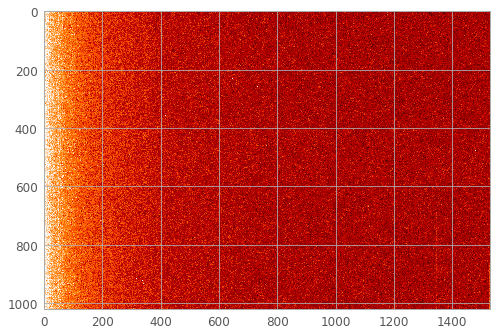

In [4]:
## plot the average bias
plt.imshow(avbias,vmin=np.mean(np.ravel(avbias))-3*np.std(np.ravel(avbias)),vmax=np.mean(np.ravel(avbias))+3*np.std(np.ravel(avbias)))

The readnoise for the CCD in ADC is 5.82


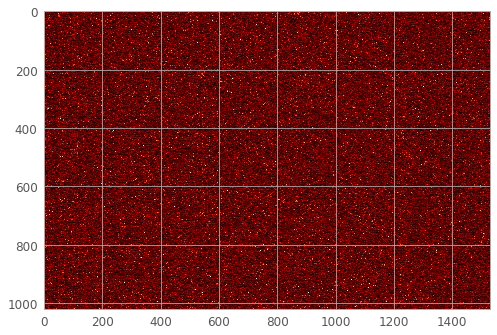

In [5]:
## plot the variance of the bias/readnoise
plt.imshow(varbias,vmin=0,vmax=np.mean(np.ravel(varbias))+3*np.std(np.ravel(varbias)))
print("The readnoise for the CCD in ADC is {:.2f}".format(np.sqrt(np.mean(np.ravel(varbias)))))

In [9]:
## Correct the flat data with the bias data
## Calculate the mean and vairance of the flat
avflatA, varflatA, gainflatA = get_the_av_var_for_flat(flatA_0)
avflatA1, varflatA1, gainflatA1 = get_the_av_var_for_flat(flatA1_0)
avflatK, varflatK, gainflatK = get_the_av_var_for_flat(flatK_0)
avflatS, varflatS, gainflatS = get_the_av_var_for_flat(flatS_0)
avflatT, varflatT, gainflatT = get_the_av_var_for_flat(flatT_0)
avflatQ, varflatQ, gainflatQ = get_the_av_var_for_flat(flatQ_0)
avflatM, varflatM, gainflatM = get_the_av_var_for_flat(flatM_0)

## Tried the slice method
# slc_flatA = flatA[:,200:500,:]
# slc_avflatA =  np.asarray(slc_flatA).mean(axis=0)
# slc_varflatA =  np.asarray(slc_flatA).var(axis=0)
# slc_gainflatA = slc_avflatA/slc_varflatA

<Figure size 432x288 with 0 Axes>

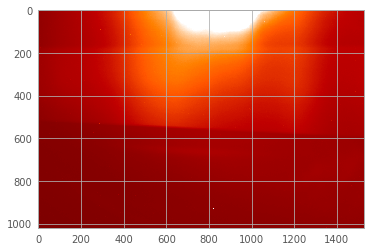

<Figure size 432x288 with 0 Axes>

In [38]:
## plot the average frame of flat
plt.imshow(avflatM,vmin=np.mean(np.ravel(avflatM))-3*np.std(np.ravel(avflatM)),vmax=np.mean(np.ravel(avflatM))+3*np.std(np.ravel(avflatM)))
plt.figure()
# plt.imshow(slc_avflatA,vmin=np.mean(np.ravel(slc_avflatA))-3*np.std(np.ravel(slc_avflatA)),vmax=np.mean(np.ravel(slc_avflatA))+3*np.std(np.ravel(slc_avflatA)))

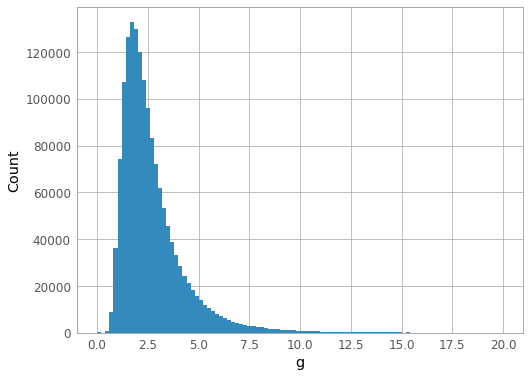

The max highest histogram happens at 1.60.
From the curve fit over all pixels, g=2.395
Using the number from histogram, the readnoise in electron is 9.045
Using the number from curve fitting, the readnoise in electron is 13.538


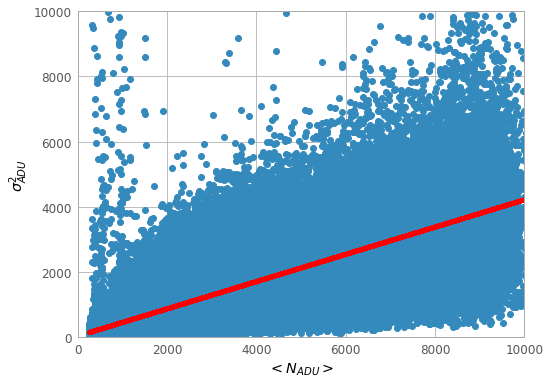

In [86]:
# 75 sec
g_histS, g_cfitS = cal_gain_and_plot(avflatS,varflatS,gainflatS)

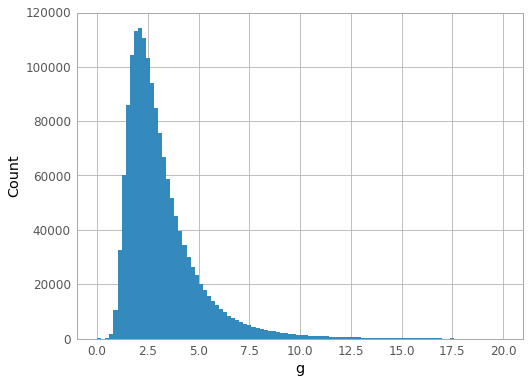

The max highest histogram happens at 2.00.
From the curve fit over all pixels, g=2.254
Using the number from histogram, the readnoise in electron is 11.307
Using the number from curve fitting, the readnoise in electron is 12.740


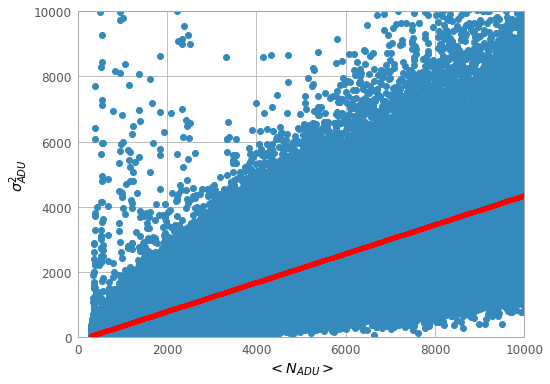

In [87]:
# 90 s
g_histA, g_cfitA = cal_gain_and_plot(avflatA,varflatA,gainflatA)

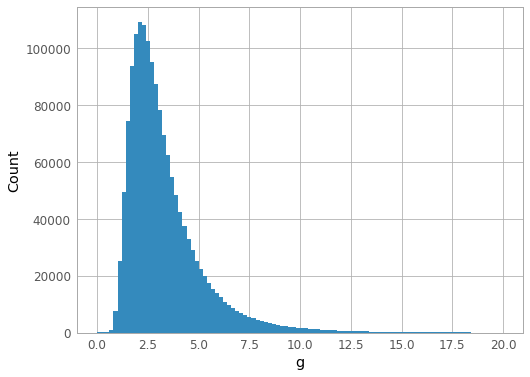

The max highest histogram happens at 2.00.
From the curve fit over all pixels, g=2.670
Using the number from histogram, the readnoise in electron is 11.648
Using the number from curve fitting, the readnoise in electron is 15.547


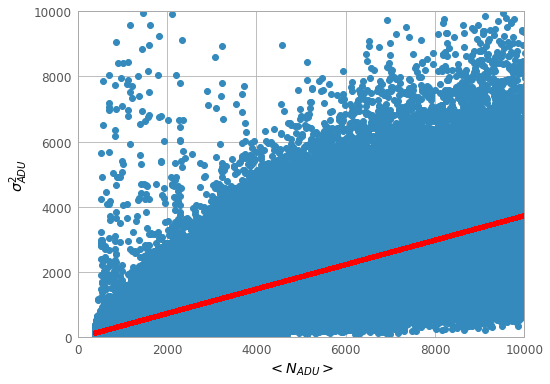

In [12]:
# 120 s
g_histT, g_cfitT = cal_gain_and_plot(avflatT,varflatT,gainflatT)

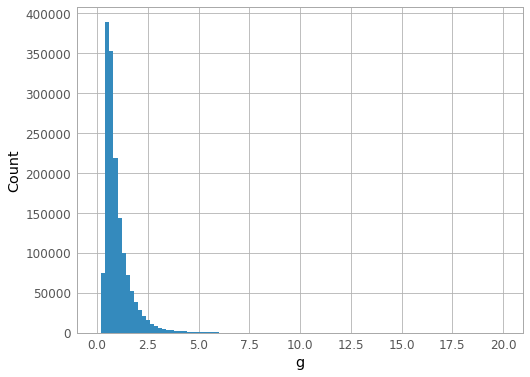

The max highest histogram happens at 0.40.
From the curve fit over all pixels, g=0.632
Using the number from histogram, the readnoise in electron is 2.330
Using the number from curve fitting, the readnoise in electron is 3.680


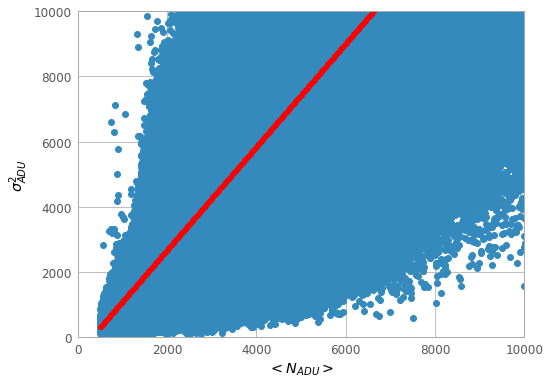

In [13]:
# 150 s
g_histA1, g_cfitA1 = cal_gain_and_plot(avflatA1,varflatA1,gainflatA1)

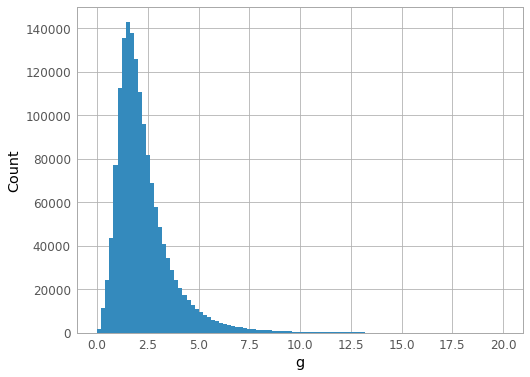

The max highest histogram happens at 1.40.
From the curve fit over all pixels, g=0.522
Using the number from histogram, the readnoise in electron is 8.154
Using the number from curve fitting, the readnoise in electron is 3.043


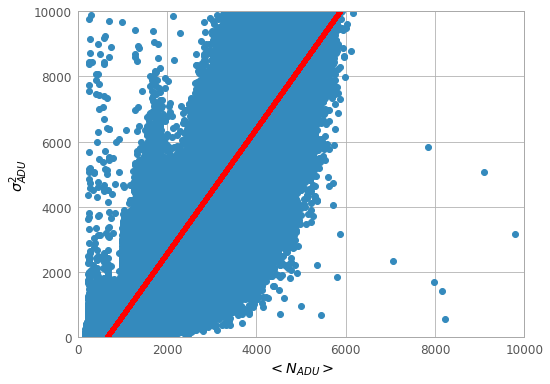

In [14]:
# 60 s
g_histM, g_cfitM = cal_gain_and_plot(avflatM,varflatM,gainflatM)

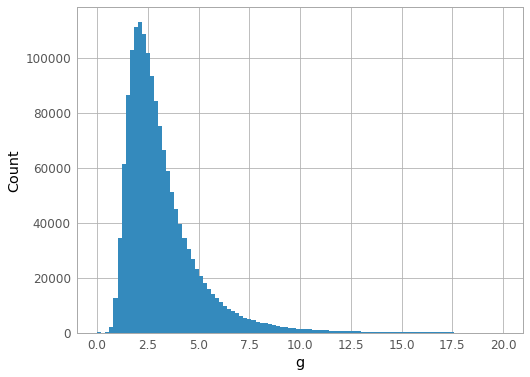

The max highest histogram happens at 2.00.
From the curve fit over all pixels, g=2.552
Using the number from histogram, the readnoise in electron is 11.648
Using the number from curve fitting, the readnoise in electron is 14.861


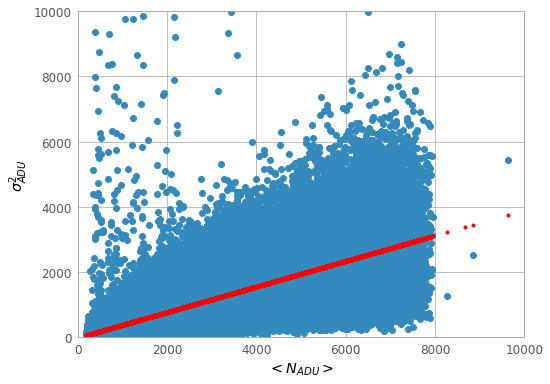

In [15]:
# 60 s
g_histK, g_cfitK = cal_gain_and_plot(avflatK,varflatK,gainflatK)

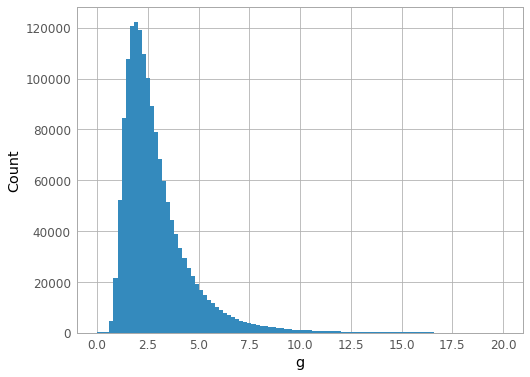

The max highest histogram happens at 1.80.
From the curve fit over all pixels, g=2.611
Using the number from histogram, the readnoise in electron is 10.483
Using the number from curve fitting, the readnoise in electron is 15.204


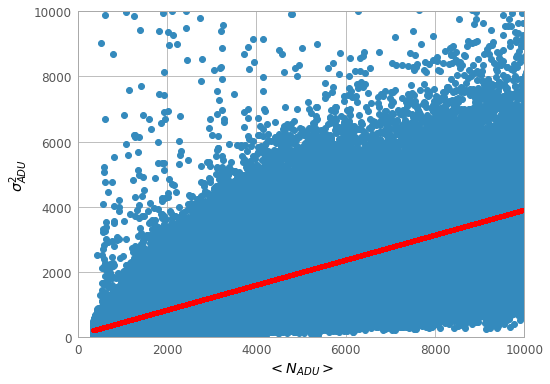

In [16]:
# 100 s
g_histQ, g_cfitQ = cal_gain_and_plot(avflatQ,varflatQ,gainflatQ)

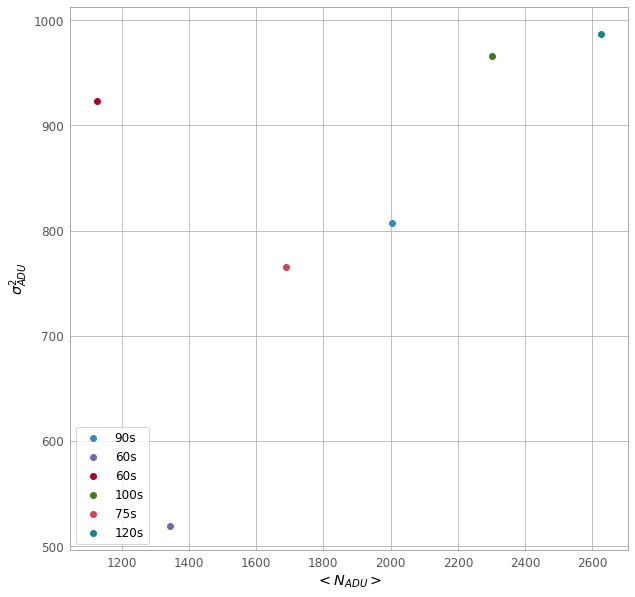

In [17]:
## Plot the variance-mean pair as a function of exposure time
plt.figure(figsize=[10,10])
plt.scatter(np.mean(avflatA),np.mean(varflatA),label='90s')
# plt.scatter(np.mean(avflatA1),np.mean(varflatA1),label='150s')
plt.scatter(np.mean(avflatK),np.mean(varflatK),label='60s')
plt.scatter(np.mean(avflatM),np.mean(varflatM),label='60s')
plt.scatter(np.mean(avflatQ),np.mean(varflatQ),label='100s')
plt.scatter(np.mean(avflatS),np.mean(varflatS),label='75s')
plt.scatter(np.mean(avflatT),np.mean(varflatT),label='120s')
plt.ylabel("$\sigma_{ADU}^2$")
plt.xlabel("$<N_{ADU}>$")
plt.legend()
plt.show()

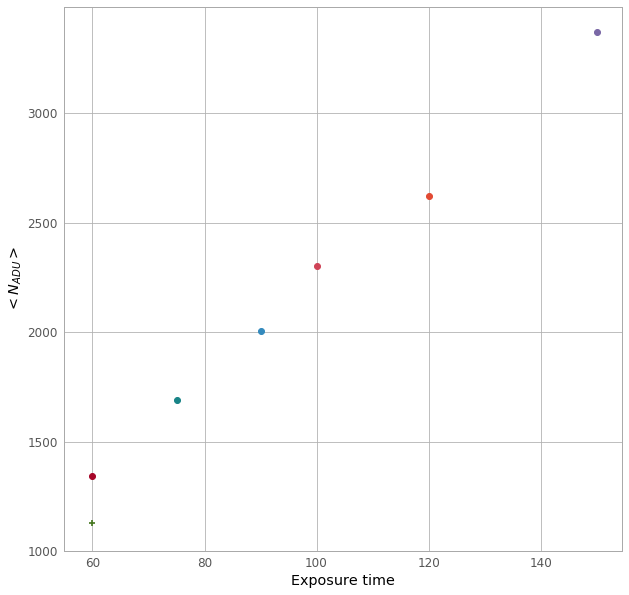

In [18]:
## Plot the mean of signal as a function of exposure time
plt.figure(figsize=[10,10])
plt.scatter(timeA,np.mean(avflatA))
plt.scatter(timeA1,np.mean(avflatA1))
plt.scatter(timeK,np.mean(avflatK))
plt.scatter(timeM,np.mean(avflatM),marker='+')
plt.scatter(timeQ,np.mean(avflatQ))
plt.scatter(timeS,np.mean(avflatS))
plt.scatter(timeT,np.mean(avflatT))
plt.xlabel('Exposure time')
plt.ylabel('$<N_{ADU}>$')
plt.show()

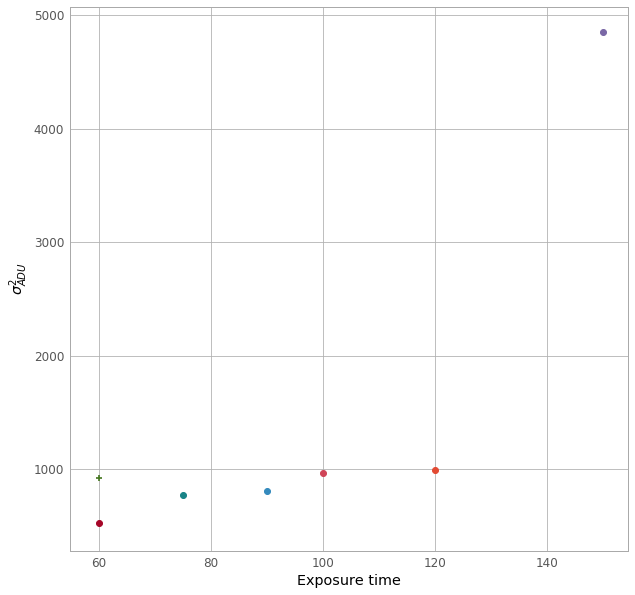

In [19]:
## Plot the variance of signal as a function of exposure time
plt.figure(figsize=[10,10])
plt.scatter(timeA,np.mean(varflatA))
plt.scatter(timeA1,np.mean(varflatA1))
plt.scatter(timeK,np.mean(varflatK))
plt.scatter(timeM,np.mean(varflatM),marker='+')
plt.scatter(timeQ,np.mean(varflatQ))
plt.scatter(timeS,np.mean(varflatS))
plt.scatter(timeT,np.mean(varflatT))
plt.xlabel('Exposure time')
plt.ylabel("$\sigma_{ADU}^2$")
plt.show()

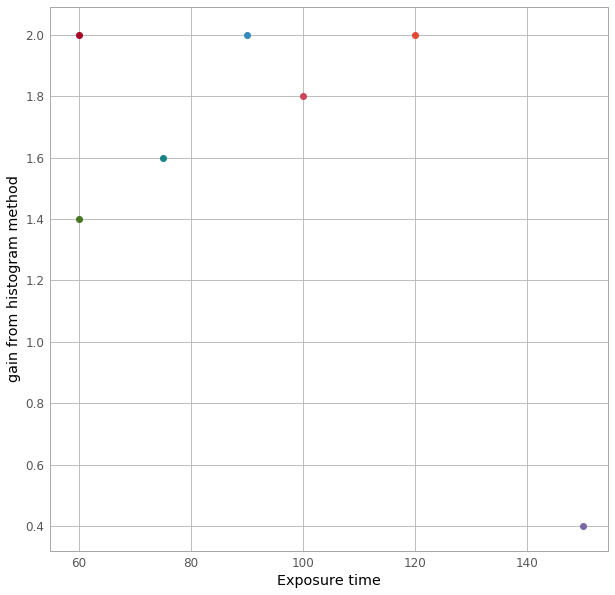

In [20]:
## Plot the gain from histogram as a function of exposure time
plt.figure(figsize=[10,10])
plt.scatter(timeA,g_histA)
plt.scatter(timeA1,g_histA1)
plt.scatter(timeK,g_histK)
plt.scatter(timeM,g_histM)
plt.scatter(timeQ,g_histQ)
plt.scatter(timeS,g_histS)
plt.scatter(timeT,g_histT)
plt.xlabel('Exposure time')
plt.ylabel('gain from histogram method')
plt.show()

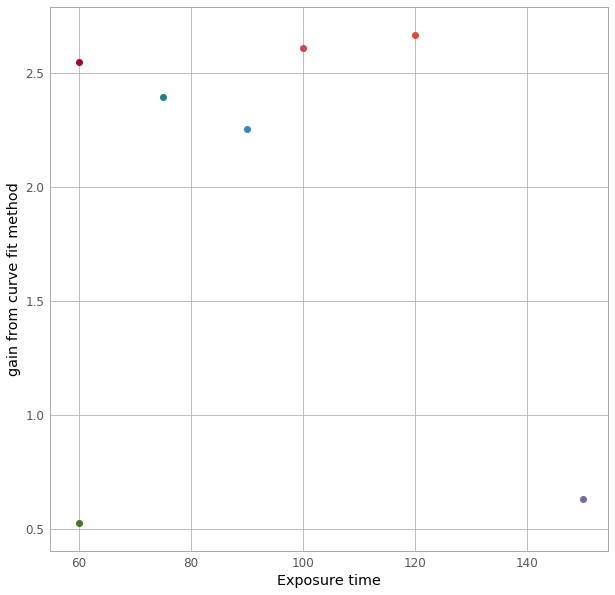

In [21]:
## Plot the gain from curvefit as a function of exposure time
plt.figure(figsize=[10,10])
plt.scatter(timeA,g_cfitA)
plt.scatter(timeA1,g_cfitA1)
plt.scatter(timeK,g_cfitK)
plt.scatter(timeM,g_cfitM)
plt.scatter(timeQ,g_cfitQ)
plt.scatter(timeS,g_cfitS)
plt.scatter(timeT,g_cfitT)
plt.xlabel('Exposure time')
plt.ylabel('gain from curve fit method')
plt.show()

## Part 2: Dark Current

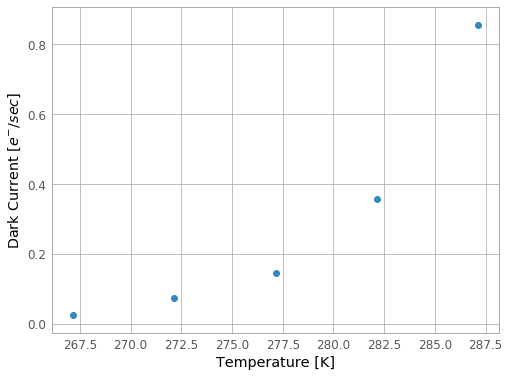

In [199]:
## Get the average dark current over all pixels 
## at different temperature and plot against temperature with 90 sec exp time

# Get the average frames for the two frames at the same temperature
darkA = get_the_av_for_dark(darkA_0,darkbias)

# Define the cutoff point at each temperature
ol_cutoffA = [25,25,28,40,60]

# Eliminate outliers and get the average over all pixels at different temperature with 90 sec exp time (ADU)
avdarkA_ol_cut_off = rm_ol_for_dark_and_get_avg(darkA,ol_cutoffA)

# Get the average over all pixels at different temperature per unit time (ADU/sec)
avdarkA_ol_cut_off_per_time = avdarkA_ol_cut_off/time_dark

# Get the average over all pixels at different temperature per unit time in e- (e-/sec)
# Using the gain from the 90 sec flat fields using hist method
avdarkA_ol_cut_off_per_time_e = avdarkA_ol_cut_off_per_time*g_histA

plt.scatter(temp_dark[:],avdarkA_ol_cut_off_per_time_e[:])
plt.xlabel('Temperature [K]')
plt.ylabel('Dark Current [$e^{-}/sec$]')
plt.show()

In [200]:
def func_dark (x,A,E_g):
    return A*x**(3/2)*np.exp(-E_g/(2*k*x))

A = 4.40E+16 and E_g = 2.32E+00


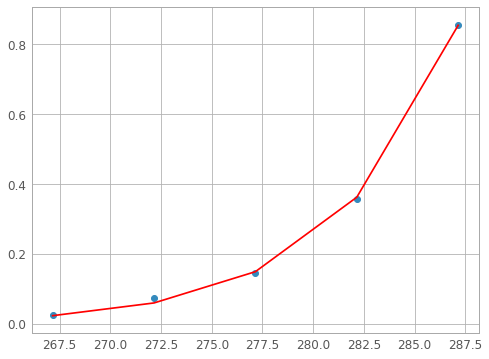

In [201]:
## Curve fit to find the constants A and E_g
# Provide initial estimates for the parameters
A0,E_g0 = (3e13,2)

# exectute the curve fit...
coeffs, fiterr = curve_fit(func_dark, temp_dark[:], avdarkA_ol_cut_off_per_time_e[:], p0=(A0,E_g0))

# ...and plot the results
print ("A = {:.2E} and E_g = {:.2E}".format(coeffs[0],coeffs[1]))
plt.scatter(temp_dark[:],avdarkA_ol_cut_off_per_time_e[:])
plt.plot(temp_dark[:],func_dark(temp_dark[:],*coeffs),'r')
# plt.xlim([0,10000])
# plt.ylim([0,10000])
plt.show()

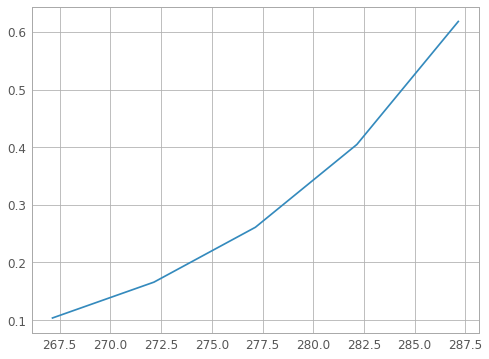

In [113]:
# random plotting to determine the initial parameter for A and E_g
plt.plot(temp_dark,func_dark(temp_dark,7e5,1.11))
plt.show()

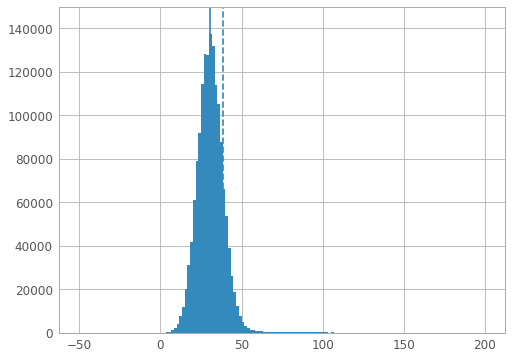

In [82]:
# Determine cut off and examine the effect
i = 4
plt.hist(np.ravel(darkA[i]),150,range=(-50,200))
plt.axvline(avdarkA_ol_cut_off[i])
plt.axvline(np.mean(darkA[i]),linestyle='--')
plt.ylim([0,150000])
plt.show()

## Junk

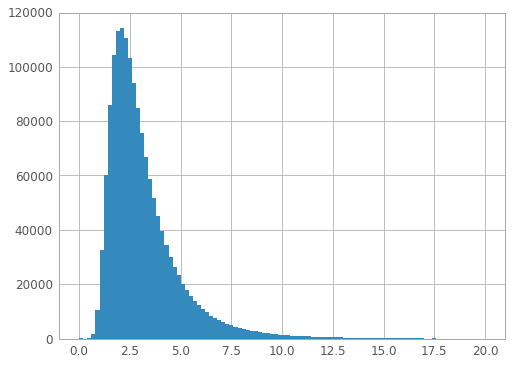

The max highest histogram happens at 2.00.


In [88]:
## plot the histogram of the distribution of gain at integration 90s
n, bins, _ = plt.hist(np.ravel(gainflatA),100,range=(0,20))
plt.show()
print('The max highest histogram happens at {:.2f}.'.format(bins[np.where(n == max(n))][0]))

g=2.25358666116
Therefore, the readnoise in electron is 76.442


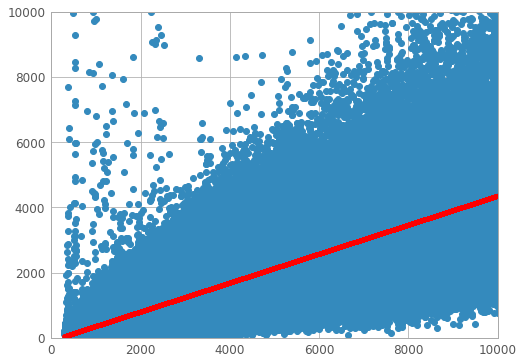

In [96]:
## Plot the variance versus the mean of all the pixels in the flat image at 90 sec
plt.scatter(np.ravel(avflatA),np.ravel(varflatA))

# choose the function to be fitted... 
def func (x,g,k):
    return x/g+k

# ...and provide initial estimates for the parameters
g0,k0 = (1,0.05)

# exectute the curve fit...
coeffs, fiterr = curve_fit(func, np.ravel(avflatA), np.ravel(varflatA), p0=(g0,k0))

# ...and plot the results
print ("g=%s" % (coeffs[0]))
print("Therefore, the readnoise in electron is {:.3f}".format(coeffs[0]*np.mean(np.ravel(varbias))))
plt.plot(np.ravel(avflatA),func(np.ravel(avflatA),*coeffs),'r.')
plt.xlim([0,10000])
plt.ylim([0,10000])
plt.show()

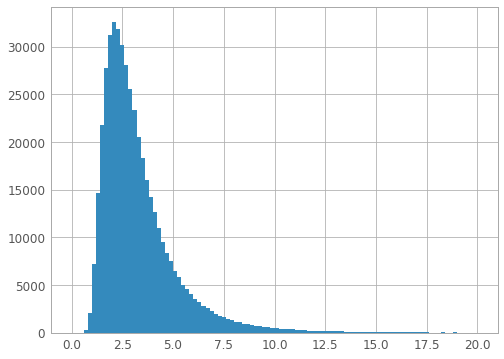

The max highest histogram happens at 2.00.


In [92]:
## plot the histogram of the distribution of gain at integration 90s with only a slice
n, bins, _ = plt.hist(np.ravel(slc_gainflatA),100,range=(0,20))
plt.show()
print('The max highest histogram happens at {:.2f}.'.format(bins[np.where(n == max(n))][0]))

g=2.59794531319


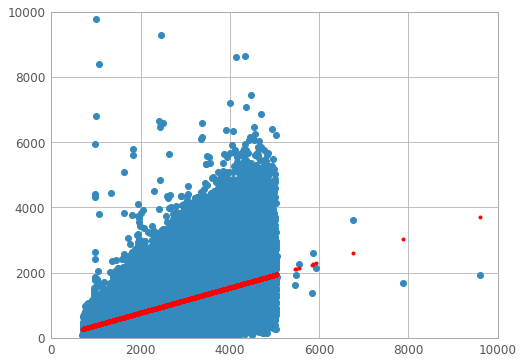

In [93]:
## Plot the variance versus the mean of all the pixels in the flat image at 90 sec with only a slice
plt.scatter(np.ravel(slc_avflatA),np.ravel(slc_varflatA))

# choose the function to be fitted... 
def func (x,g):
    return x/g

# ...and provide initial estimates for the parameters
g0 = (1)

# exectute the curve fit...
coeffs, fiterr = curve_fit(func, np.ravel(slc_avflatA), np.ravel(slc_varflatA), p0=(g0))

# ...and plot the results
print ("g=%s" % (coeffs[0]))
plt.plot(np.ravel(slc_avflatA),func(np.ravel(slc_avflatA),*coeffs),'r.')
plt.xlim([0,10000])
plt.ylim([0,10000])
plt.show()